# Generating Dataset

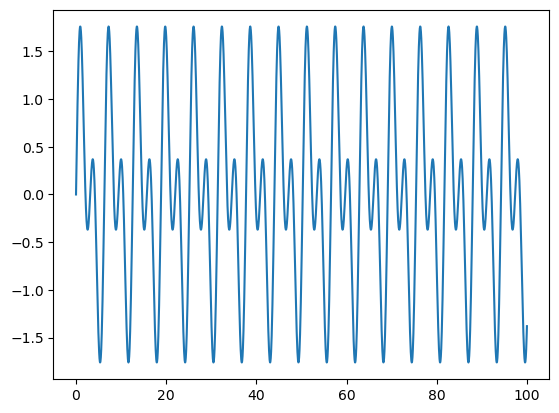

In [104]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

num_data = 2400
t = np.linspace(0.0, 100.0, num_data) #0부터시작해서 100으로 끝나는데 num_data개수만큼 생성
y = np.sin(t) + np.sin(2*t)
e = np.random.normal(0, 0.1, num_data)
y = y

plt.plot(t, y)

In [105]:
seq_len = 10
X = []
y_true = []

for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    
X = np.array(X)
y_true = np.array(y_true)

#seqence data를 사용할 때 차원 => [seq len, batch_size, input_dim]
"""
for x in X:
    print(x.shape)
=> [ batch_size, input_dim ]
"""
# X [2390,10] => [10, batch_size, 1]
# (2390, 10) => (10, 2390)
X = np.swapaxes(X, 0, 1)
# (10, 2390) => (10, 2390, 1)
X = np.expand_dims(X, axis=2)

# Model Define

In [106]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size):
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size
        
        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False)
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias=False)
        
        self.act = nn.Tanh()

        self.hidden = self.init_hidden()
                
    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)
    
    def forward(self, x):
        h = self.act(self.u(x) + self.w(self.hidden))
        y = self.v(h)
        # hidden이 update 되고 forward되어야하기 때문에 h도 return
        return y, h

# Train Trigonometric Function

In [107]:
#input_dim, output_dim, hid_dim, batch_size
model = RNN(1, 1, 50, 2390)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
epoch = 100

# =====Train===== #
model.train()

for epoch in range(epoch):
    model.zero_grad()
    optimizer.zero_grad()
    
    model.hidden = model.init_hidden()
    
    for x in X:
        #x => (2390, 1) * 10
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()
        y_pred, hidden = model(x)
        model.hidden = hidden

    # loss 계산시 차원을 맞춤 view말고 squeeze를 쓰는 방법도 있음
    loss = loss_fn(y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()
    print(loss.item())

0.2890920341014862
0.2276630997657776
0.18047760426998138
0.14424429833889008
0.11642840504646301
0.09507784992456436
0.07868991047143936
0.06610844284296036
0.05644465610384941
0.0490158349275589
0.04329795762896538
0.03888919949531555
0.035481613129377365
0.03283941000699997
0.030782142654061317
0.029171817004680634
0.027902953326702118
0.026894962415099144
0.02608630433678627
0.025429997593164444
0.02489018812775612
0.02443952113389969
0.024057133123278618
0.023727109655737877
0.02343731001019478
0.02317848615348339
0.022943580523133278
0.02272721379995346
0.022525282576680183
0.022334661334753036
0.022152958437800407
0.021978361532092094
0.021809471771121025
0.021645227447152138
0.021484818309545517
0.02132762409746647
0.02117317169904709
0.02102108858525753
0.020871097221970558
0.020722979679703712
0.020576568320393562
0.02043173275887966
0.020288364961743355
0.02014639414846897
0.02000574767589569
0.019866380840539932
0.019728243350982666
0.019591307267546654
0.019455542787909508

# Predict Target Function

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2390


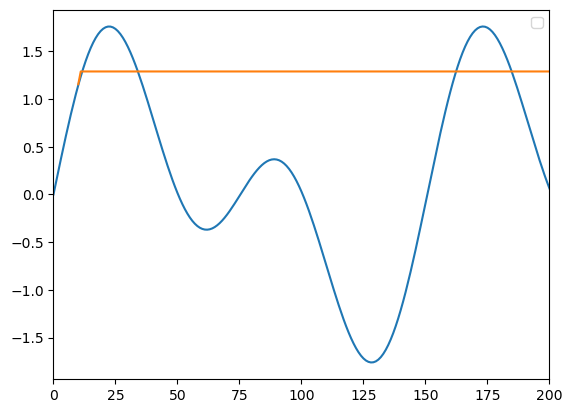

In [111]:
test_X = np.expand_dims(X[:, 0, :], 1) #(10, 1, 1) (seq_len, batch_size, input_dim)
list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)
    
    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())
    
    temp_X = list()
    temp_X += list(np.squeeze(test_X))[1:]
    temp_X.append(y_pred.view(-1).item())
    
    for i in range(2389):
        model.hidden = model.init_hidden(batch_size=1)
        temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X), 1), 1)
        
        for x in temp2_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        
        y_pred, hidden = model(y_pred)
        list_y_pred.append(y_pred.view(-1).item())
    
    print(len(list_y_pred))
    
plt.plot(y)
plt.plot(list(range(10, 2400)), list_y_pred)
plt.xlim(0, 200)
plt.legend()